In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
  def __init__(self, data, _children=(), _op='', label='') -> None:
    self.data = data
    self.grad = 0.0     # 初始化 梯度为0.0
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self) -> str:
    """
      data wrapper
      用来覆写 print() 方法的输出结果
    """
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    """
      用来覆写 + 的输出结果
    """
    out = Value(self.data + other.data, (self, other), '+')
    return out
  
  def __mul__(self, other):
    """
      用来覆写 * 的输出结果
    """
    out = Value(self.data * other.data, (self, other), '*')
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
    out = Value(t, (self, ), 'tanh')
    return out



In [3]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})   # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      #  add connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [4]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')

L = d * f; L.label = 'L'
L

Value(data=-8.0)

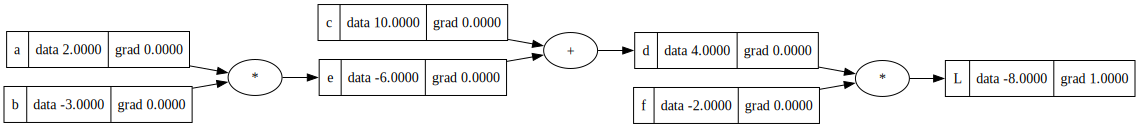

In [5]:
L.grad = 1.0    # L节点对于L节点自己的梯度 就是1.

"""
  下图中的所有节点的 grad 计算的都是当前节点对于 L节点的梯度。
  例如：节点e的grad 就是 de / dL
"""
draw_dot(L)

In [6]:
def lol():
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')

  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')

  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')

  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')

  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

-3.9999999999995595


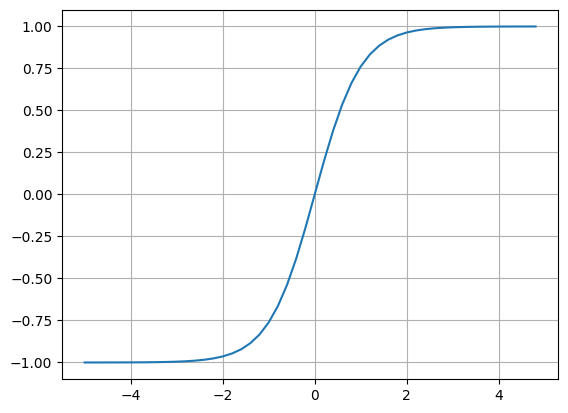

In [7]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

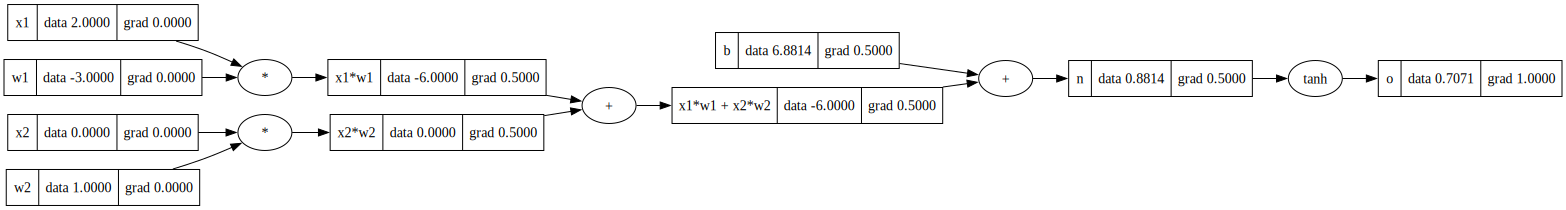

In [16]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function
o = n.tanh(); o.label = 'o'
o.grad = 1.0  # 因为 激活函数tanh 对于自己的 梯度 do / do 也是1，所以我们将 o 的grad设置为1.0:

# o = tanh(n)的导数为： 1 - tanh^2(n)
n.grad = round(1 - o.data ** 2, 4)

x1w1x2w2.grad = .5
b.grad = .5

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1w1.grad = .5; x2w2.grad = .5

draw_dot(o)